In [10]:
from src.common.files import get_processed_paths
import zarr
import numpy as np
from src.dataset.zarr import combine_zarr_datasets
import matplotlib.pyplot as plt

# Import dimmensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [39]:
z_real = get_processed_paths(
    controller="diffik",
    domain="real",
    task="one_leg_full",
    demo_source="teleop",
    demo_outcome="success",
    randomness="low",
    suffix=None,
)


real, _ = combine_zarr_datasets(
    z_real,
    [
        "robot_state",
        "action/pos",
    ],
    max_episodes=None,
    max_ep_cnt=None,
)

real_robot_state = real["robot_state"]
real = real["action/pos"]

real.shape

Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]



Loading zarr files: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


(27699, 10)

In [40]:
z_sim = get_processed_paths(
    controller="diffik",
    domain="sim",
    task="one_leg",
    demo_source="teleop",
    demo_outcome="success",
    randomness=["med", "med_perturb"],
    suffix=None,
)

sim, _ = combine_zarr_datasets(
    z_sim,
    [
        "robot_state",
        "action/pos",
    ],
    max_episodes=None,
    max_ep_cnt=None,
)

sim_robot_state = sim["robot_state"]
sim = sim["action/pos"]

sim.shape

Loading zarr files:   0%|          | 0/2 [00:00<?, ?it/s]









Loading zarr files: 100%|██████████| 2/2 [00:00<00:00, 25.05it/s]


(24091, 10)

In [51]:
dim_names = ["x", "y", "z"]

simcolor = "#2398DA"
realcolor = "#E34A6F"


def plot_cross_section(ax, sim, real, dims):
    d1, d2 = dims

    # Plot the real data
    ax.scatter(real[:, d1], real[:, d2], alpha=0.05, c=realcolor, s=1)
    # Plot the sim data
    ax.scatter(sim[:, d1], sim[:, d2], alpha=0.05, c=simcolor, s=1)

    # Add a legend
    ax.scatter([], [], c=realcolor, label="real")
    ax.scatter([], [], c=simcolor, label="sim")

    ax.legend(frameon=False, fontsize=16)

    ax.set_xlabel(dim_names[dims[0]])
    ax.set_ylabel(dim_names[dims[1]])

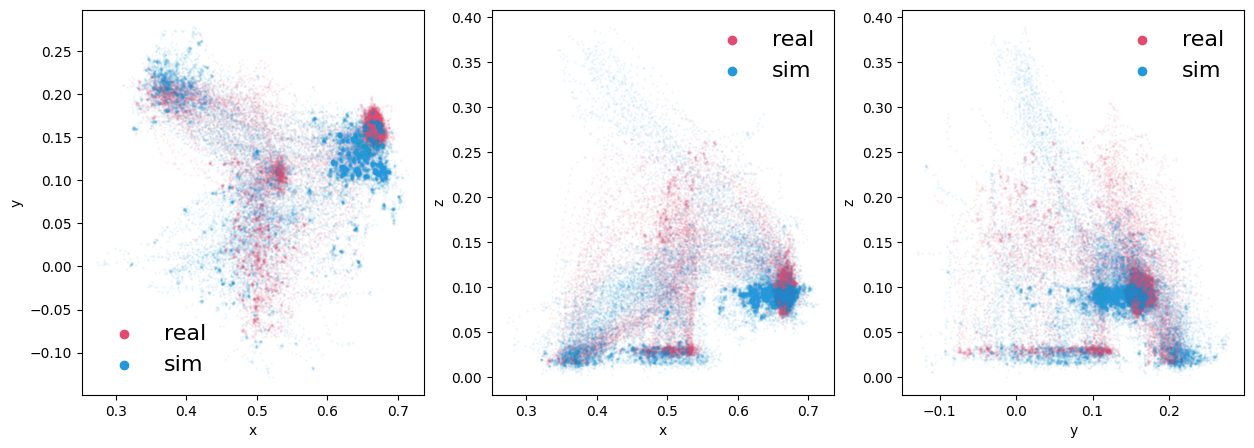

In [52]:
# More simply, plot the 3 cross-section position of the end effector for the sim and real data in one plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Add some random noise to the data to make the scatter plot more readable
real_dispersed = real  # + np.random.normal(0, 0.001, real.shape)
sim_dispersed = sim  # + np.random.normal(0, 0.001, sim.shape)

plot_cross_section(axs[0], sim_dispersed, real_dispersed, [0, 1])
plot_cross_section(axs[1], sim_dispersed, real_dispersed, [0, 2])
plot_cross_section(axs[2], sim_dispersed, real_dispersed, [1, 2])

# fig.suptitle(
#     "Cross-sections of the end effector position for sim and real data", fontsize=16
# )

In [53]:
# Save the raw data for loading and plotting in another script
np.save("data/sim_actions.npy", sim)
np.save("data/real_actions.npy", real)

In [20]:
# What's the limits in the xyz dimensions for the sim and real data?
print("Sim limits")
print(np.min(sim[:, :3], axis=0))
print(np.max(sim[:, :3], axis=0))

print("Real limits")
print(np.min(real[:, :3], axis=0))
print(np.max(real[:, :3], axis=0))

Sim limits
[ 0.2722577  -0.12987386 -0.00164136]
[0.71350646 0.27798077 0.39076424]
Real limits
[ 0.32091093 -0.10811802  0.01317929]
[0.6942844  0.23960987 0.304023  ]


In [21]:
# Difference between smallest z between sim and real
print("Difference in smallest z")
print(np.min(real[:, 2]) - np.min(sim[:, 2]))

Difference in smallest z
0.014820653


In [29]:
def get_and_concat_state_action_space(robot_state, action):

    state_action = np.concatenate([robot_state, action], axis=-1)

    return state_action

In [30]:
sa_sim = get_and_concat_state_action_space(sim_robot_state, sim)  # [:, :3]
sa_real = get_and_concat_state_action_space(real_robot_state, real)  # [:, :3]

sa = np.concatenate([sa_sim, sa_real], axis=0)
source_domain = np.concatenate([np.zeros(sa_sim.shape[0]), np.ones(sa_real.shape[0])])

print(sa_sim.shape, sa_real.shape)

(24091, 26) (27699, 26)


In [31]:
# Perform PCA and t-SNE and plot the results so we can compare the state action spaces of the sim and real data in the same space
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

pca_result = pca.fit_transform(sa)
tsne_result = tsne.fit_transform(sa)

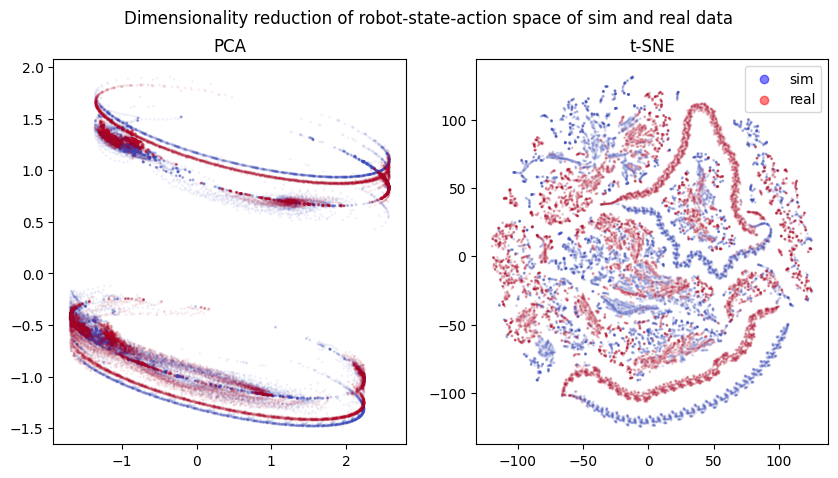

In [32]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=source_domain,
    cmap="coolwarm",
    alpha=0.05,
    s=1,
)
plt.title("PCA")

plt.subplot(1, 2, 2)
plt.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c=source_domain,
    cmap="coolwarm",
    alpha=0.05,
    s=1,
)
plt.title("t-SNE")

# Add a legend
plt.scatter([], [], c="blue", label="sim", alpha=0.5)
plt.scatter([], [], c="red", label="real", alpha=0.5)
plt.legend()

# Add a title
plt.suptitle(
    "Dimensionality reduction of robot-state-action space of sim and real data"
)

plt.show()

Text(0.5, 1.0, 'PCA component 2')

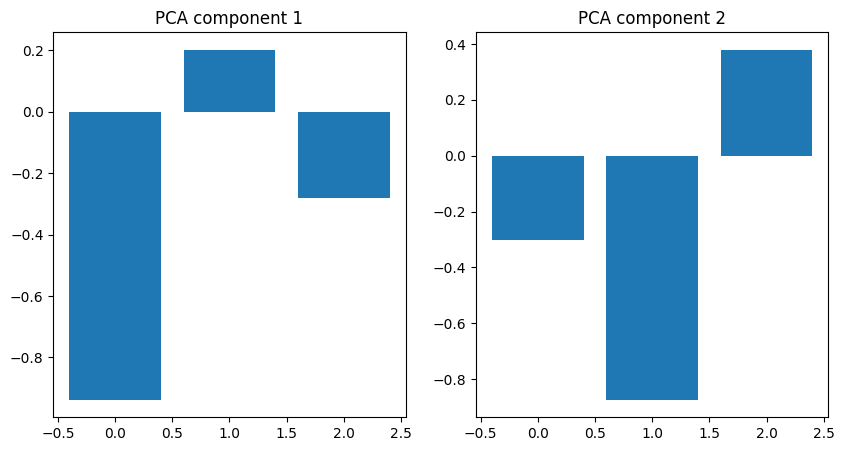

In [16]:
# Show what input features are most important for the PCA in one plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(range(len(pca.components_[0])), pca.components_[0])
axs[0].set_title("PCA component 1")

axs[1].bar(range(len(pca.components_[1])), pca.components_[1])
axs[1].set_title("PCA component 2")

In [17]:
# Perform PCA and t-SNE and plot the results so we can compare the state action spaces of the sim and real data in the same space
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

pca.fit(sa_real)
# tsne.fit(sa_real)

pca_result = pca.transform(sa)
# tsne_result = tsne.transform(sa)

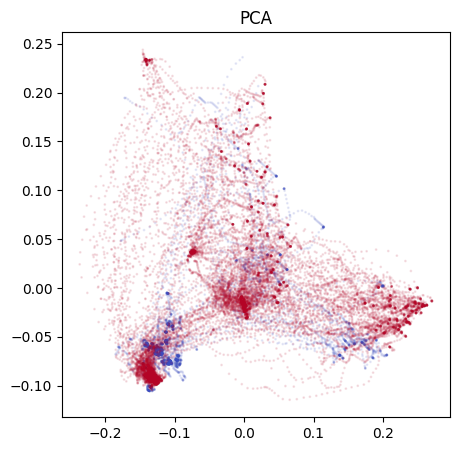

In [31]:
plt.figure(figsize=(5, 5))

plt.scatter(
    pca_result[:, 0], pca_result[:, 1], c=source_domain, cmap="coolwarm", alpha=0.1, s=1
)
plt.title("PCA")


plt.show()

### Compare histograms over the action magnitudes

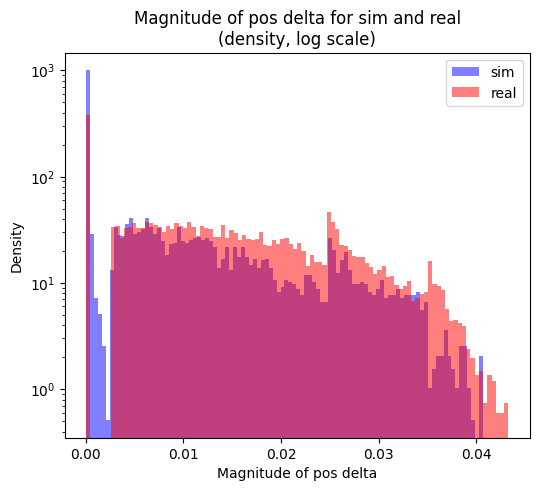

In [29]:
delta_sim = sim = z_sim["action/delta"][:, :3]
delta_real = sim = z_real["action/delta"][:, :3]

delta_sim_mag = np.linalg.norm(delta_sim, axis=-1)
delta_real_mag = np.linalg.norm(delta_real, axis=-1)

plt.figure(figsize=(6, 5))

plt.hist(
    delta_sim_mag,
    bins=100,
    alpha=0.5,
    color="blue",
    label="sim",
    density=True,
    log=True,
)
plt.hist(
    delta_real_mag,
    bins=100,
    alpha=0.5,
    color="red",
    label="real",
    density=True,
    log=True,
)

plt.title("Magnitude of pos delta for sim and real\n(density, log scale)")
plt.xlabel("Magnitude of pos delta")
plt.ylabel("Density")

plt.legend()